Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.6661 - loss: 0.5819 - val_accuracy: 0.7995 - val_loss: 0.4431
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.8152 - loss: 0.4125 - val_accuracy: 0.8145 - val_loss: 0.4182
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8264 - loss: 0.3810 - val_accuracy: 0.8275 - val_loss: 0.3899
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8491 - loss: 0.3460 - val_accuracy: 0.8230 - val_loss: 0.3899
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8540 - loss: 0.3244 - val_accuracy: 0.8225 - val_loss: 0.3925
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1010
           1       0.79      0.87      0.83       990

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.

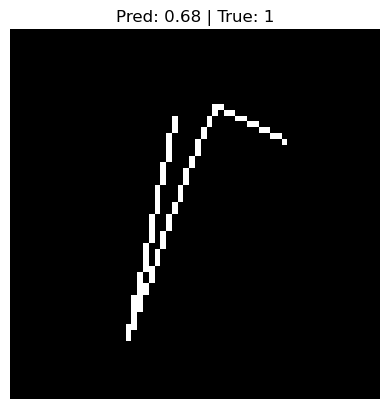

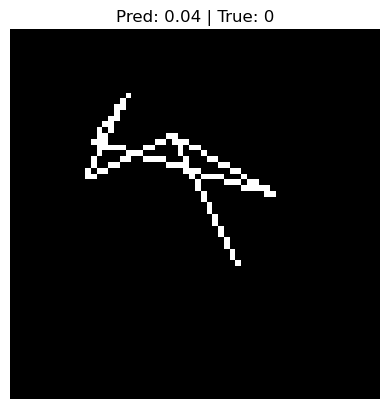

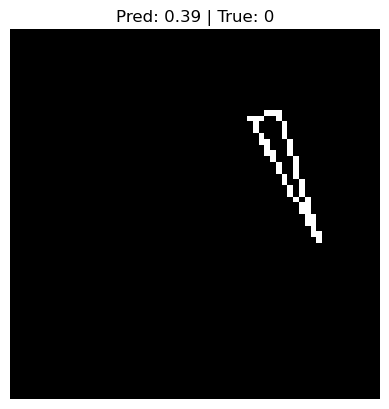

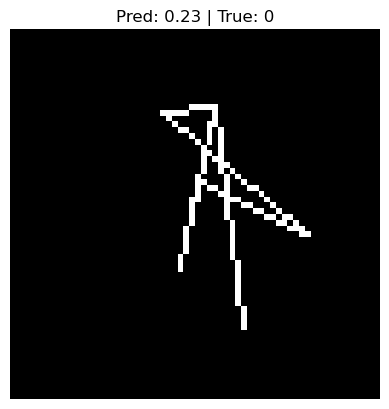

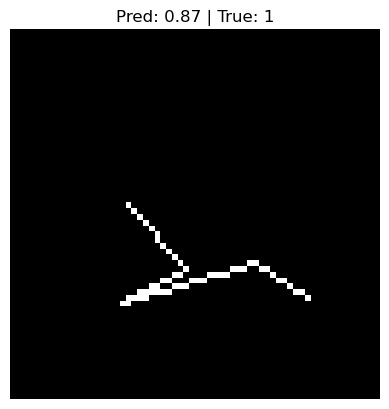

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow
from shapely.geometry import LineString
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#  Generate synthetic dataset
def generate_curve(simple=True, size=64, max_attempts=10):
    for _ in range(max_attempts):
        img = np.zeros((size, size), dtype=np.uint8)
        num_points = np.random.randint(4, 10)
        points = np.random.randint(10, size - 10, size=(num_points, 2))

        if not simple:
            points = np.vstack([points, points[1]])  # Encourage self-intersection

        line = LineString(points)
        is_actually_simple = line.is_simple

        if is_actually_simple == simple:
            cv2.polylines(img, [points], isClosed=False, color=255, thickness=1)
            return img, int(is_actually_simple)

    # fallback if no good sample was found
    cv2.polylines(img, [points], isClosed=False, color=255, thickness=1)
    return img, int(is_actually_simple)

X = []
y = []

while len(X) < 10000:
    is_simple = np.random.rand() > 0.5
    img, label = generate_curve(simple=is_simple)
    X.append(img)
    y.append(label)

X = np.array(X)[..., np.newaxis] / 255.0  # Normalize and add channel
y = np.array(y)

# --- Step 2: Split the dataset ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Epoch 1/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6900 - loss: 0.5561 - val_accuracy: 0.8085 - val_loss: 0.4143
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8211 - loss: 0.4045 - val_accuracy: 0.8195 - val_loss: 0.3976
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8297 - loss: 0.3667 - val_accuracy: 0.8240 - val_loss: 0.3904
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8406 - loss: 0.3559 - val_accuracy: 0.8260 - val_loss: 0.3843
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.8471 - loss: 0.3294 - val_accuracy: 0.8280 - val_loss: 0.3851
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1010
           1       0.82      0.84      0.83       990

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83

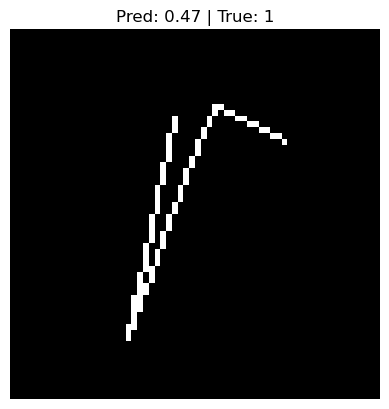

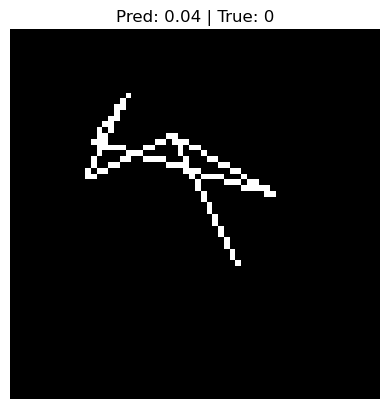

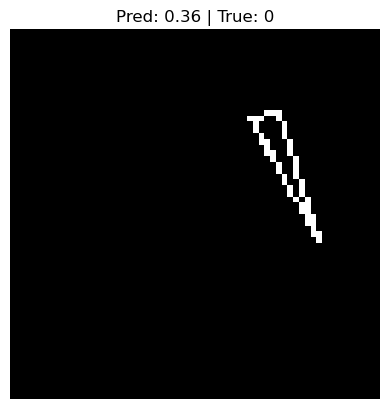

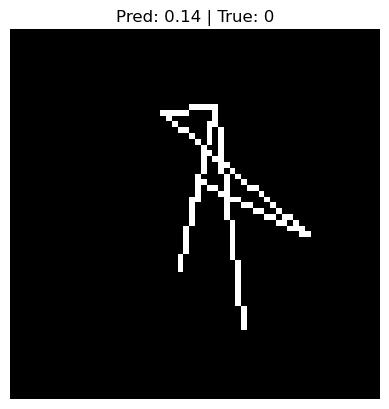

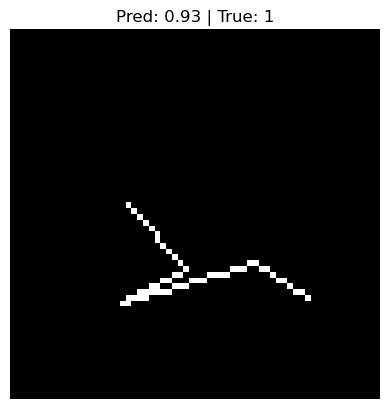

In [3]:
# --- Step 3: Define the CNN model ---
model = models.Sequential([
    layers.Input(shape=(64, 64, 1)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=20, validation_data=(X_test, y_test))

# --- Step 4: Evaluate and visualize results ---
preds = model.predict(X_test)
y_pred_binary = (preds.flatten() > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

for i in range(5):
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.title(f"Pred: {preds[i][0]:.2f} | True: {y_test[i]}")
    plt.axis('off')
    plt.show()